# Julia notebook for OCT and holistic regression

In [1]:
using Gurobi, JuMP
using CSV, DataFrames
using LinearAlgebra, Random, Statistics
using PyPlot

In [6]:
data = CSV.read("processed_data.csv", DataFrame)
train = data[data[:, "unitNumber"] .<= 80, :]
test = data[data[:, "unitNumber"] .>80, :];

features = ["timeCycles","setting1","setting2","T24","T30","T50","P30","Nf","Nc","Ps30","phi","NRf","NRc","BPR","htBleed","W31","W32"];

X = Matrix(data[:, features])
X_train, y_train = train[:, features], train[:, "RUL"]
X_test, y_test = test[:, features], test[:, "RUL"];

In [8]:
X_train_norm = (X_train .- minimum(X, dims = 1)) ./ (maximum(X, dims = 1) - minimum(X, dims = 1))
X_test_norm = (X_test .- minimum(X, dims = 1)) ./ (maximum(X, dims = 1) - minimum(X, dims = 1));

In [9]:
# Create a function that transforms the matrix input matrix by adding non-linear transformations to all columns
function transform_data(X, eps = 1.0)

    n, p = size(X) # Store the matrix dimension
    # Initiate the transformed matrix with the first feature
    Xt = hcat(X[:,1], X[:,1].^2, X[:,1].^0.5, exp.(X[:,1]), log.(abs.(X[:,1]) .+ eps))

    # Loop for all other features and concatenate the transformations to the matrix
    for i = 2:p
        Xt = hcat(Xt, X[:,i], X[:,i].^2, X[:,i].^0.5, exp.(X[:,i]), log.(abs.(X[:,i]) .+ eps))
    end

    return Xt;

end;

In [10]:
features_transformed = [pre * f for f in features for pre in ["", "squared_", "root_", "exp_", "log_"]];

In [11]:
# Create a function that returns a list of feature couples whose correlation exceeds rho
function pairwise_correlation(X, rho)

    _, p = size(X) # Store the number of features
    cor_matrix = cor(X); # Compute the correlation matrix
    cor_variables = [] # Initialize an empty list to store all pairwise correlated features couples

    for i = 1:p 
        for j = 1:i-1 # Loop under all values of the lower diagonal of the correlation matrix

            if abs(cor_matrix[i,j]) > rho
                # If the correlation coefficient of features i and j exceeds rho, append the couple to the list
                push!(cor_variables, (i,j))
            end
            
        end
    end

    return cor_variables;

end;

In [12]:
function holistic_regression(X, y, rho, lambda, k, M)

    # Create the transformed matrix
    X_transformed = transform_data(X);
    n, p = size(X) # Store the input matrix size
    _, p_tilde = size(X_transformed) # Set the number of features in the transformed matrix
    augmentation = Int(p_tilde / p)
    # Compute the list of correlated feature couples
    HC = pairwise_correlation(X_transformed, rho)

    # Create JuMP model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Introduce model variables
    @variable(model, Beta[1:p_tilde])
    @variable(model, a[1:p_tilde] >= 0)
    @variable(model, z[1:p_tilde], binary = true)

    # Robustness term constraint linearization
    @constraint(model,[j = 1:p_tilde], Beta[j] <= a[j])
    @constraint(model,[j = 1:p_tilde], -Beta[j] <= a[j])

    # Big-M integer constraint for sparsity
    @constraint(model,[j = 1:p_tilde], Beta[j] <= M*z[j])
    @constraint(model,[j = 1:p_tilde], Beta[j] >= -M*z[j])
    # Sparsity constraint
    @constraint(model, sum(z[j] for j = 1:p_tilde) <= k)

    # Non-linear transformations constraint
    @constraint(model, [j = 1:p], sum(z[augmentation*(j-1)+i] for i = 1:augmentation) <= 1)

    # Pairwise collinearity
    @constraint(model, [i = 1:length(HC)], z[HC[i][1]] + z[HC[i][2]] <= 1)

    # Implement the objective function of the problem
    @objective(model, Min, sum((y[i] - sum(X_transformed[i,j]*Beta[j] for j=1:p_tilde))^2 for i = 1:n) + lambda * sum(a[j] for j = 1:p_tilde))

    # Solve the optimization problem
    optimize!(model);

    Beta, z = JuMP.value.(Beta), Int.(JuMP.value.(z))

    y_pred = X_transformed * Beta
    r2 = 1 - sum((y_pred .- y).^2) / sum((mean(y) .- y).^2)
    print("Training R2: $(r2)")

    return Beta, value.(z), r2

end;

In [18]:
# Specify the holisitic regression problem parameters
rho = 0.99
lambda = 1
k = 10
M = 100

# Compute the holistic regression model
Beta, z, _ = holistic_regression(X_train_norm, y_train, rho, lambda, k, M);
X_test_transformed = transform_data(X_test_norm)
y_pred = X_test_transformed * Beta
r2 = 1 - sum((y_pred .- y_test).^2) / sum((mean(y_train) .- y_test).^2)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6981288756932302

0.5867697219826014

In [33]:
# Validation grid-search
# Vary rho
lambda = 1
k = 10
maes, r2s = [], []
for rho in [0.8, 0.85, 0.9]
    mae_sum, r2_sum = 0, 0
    for seed = 1:3
        (X_train_, y_train_), (X_val, y_val) = IAI.split_data(:regression, X_train_norm, y_train, seed = seed, train_proportion = 0.8)
        X_val_transformed = transform_data(X_val)
        println("Seed ", seed, "  rho ", rho)
        Beta, _, _ = holistic_regression(X_train_, y_train_, rho, lambda, k, M);
        y_pred = X_val_transformed * Beta
        r2 = 1 - sum((y_pred .- y_val).^2) / sum((mean(y_train_) .- y_val).^2)
        mae = mean(abs.(y_pred .- y_val))
        mae_sum = mae_sum + mae
        r2_sum = r2_sum + r2
    end
    push!(maes, mae_sum / 3)
    push!(r2s, r2_sum / 3)
end

### BEST RHO = 0.85

Seed 1  rho 0.8
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.7008777411465914Seed 2  rho 0.8
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6938308651094482Seed 3  rho 0.8
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6978038652739391Seed 1  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.7016768706506833Seed 2  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6947557570357674Seed 3  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6986194867970207Seed 1  rho 0.9
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.7016768706506833Seed 2  rho 0.9
Set parameter U

In [36]:
# Validation grid-search
# Vary k
lambda = 1
rho = 0.85
maes, r2s = [], []
for k in [5, 10, 25, 50]
    mae_sum, r2_sum = 0, 0
    for seed = 1:3
        (X_train_, y_train_), (X_val, y_val) = IAI.split_data(:regression, X_train_norm, y_train, seed = seed, train_proportion = 0.8)
        X_val_transformed = transform_data(X_val)
        println("Seed ", seed, "  rho ", rho)
        Beta, _, _ = holistic_regression(X_train_, y_train_, rho, lambda, k, M);
        y_pred = X_val_transformed * Beta
        r2 = 1 - sum((y_pred .- y_val).^2) / sum((mean(y_train_) .- y_val).^2)
        mae = mean(abs.(y_pred .- y_val))
        mae_sum = mae_sum + mae
        r2_sum = r2_sum + r2
    end
    push!(maes, mae_sum / 3)
    push!(r2s, r2_sum / 3)
end

### OPTIMAL k = 10

Seed 1  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6911033384756462Seed 2  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6843053046303034Seed 3  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6883228190566911Seed 1  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.7016768706506833Seed 2  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6947557570357674Seed 3  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6986194867970207Seed 1  rho 0.85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.7031197851076Seed 2  rho 0.85
Set parameter

In [48]:
# Validation grid-search
# Vary lambda
k = 10
rho = 0.85
maes, r2s = [], []
for lambda in [0.001]
    mae_sum, r2_sum = 0, 0
    for seed = 1:3
        (X_train_, y_train_), (X_val, y_val) = IAI.split_data(:regression, X_train_norm, y_train, seed = seed, train_proportion = 0.8)
        X_val_transformed = transform_data(X_val)
        println("\nSeed ", seed, "  rho ", rho, "\n")
        Beta, _, _ = holistic_regression(X_train_, y_train_, rho, lambda, k, M);
        y_pred = X_val_transformed * Beta
        r2 = 1 - sum((y_pred .- y_val).^2) / sum((mean(y_train_) .- y_val).^2)
        mae = mean(abs.(y_pred .- y_val))
        mae_sum = mae_sum + mae
        r2_sum = r2_sum + r2
    end
    push!(maes, mae_sum / 3)
    push!(r2s, r2_sum / 3)
end


Seed 1  rho 0.85

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.7016768707103528
Seed 2  rho 0.85

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6947557574870986
Seed 3  rho 0.85

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6986194871784666

In [59]:
# OPTIMAL PARAMETERS
rho = 0.85
lambda = 0.1
k = 10

X_test_transformed = transform_data(X_test_norm)
Beta, z, _ = holistic_regression(X_train_norm, y_train, rho, lambda, k, M);
y_pred = X_test_transformed * Beta;

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Training R2: 0.6981288759168376

In [60]:
1 - sum((y_pred .- y_test).^2) / sum((mean(y_train) .- y_test).^2)

0.5867707821800393

In [61]:
(mean((y_pred .- y_test).^2))

2574.0757925644416

In [62]:
mean(abs.(y_pred .- y_test))

38.30073110647964

In [91]:
findall(z .== 1)

10-element Vector{Int64}:
  3
 20
 26
 33
 45
 50
 54
 58
 79
 84

In [83]:
features_transformed[findall(z .== 1)]

10-element Vector{String}:
 "root_timeCycles"
 "log_T24"
 "T50"
 "root_P30"
 "log_Nc"
 "log_Ps30"
 "exp_phi"
 "root_NRf"
 "exp_W31"
 "exp_W32"

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


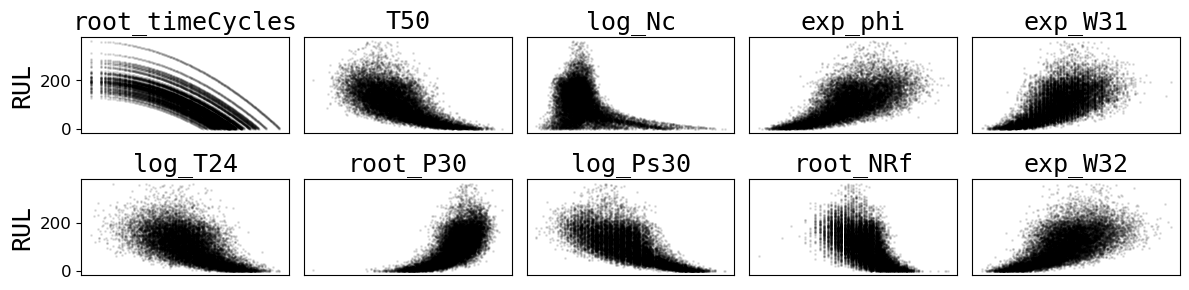

In [118]:
fig, axs = subplots(2, 5, figsize = (12, 3))

for (ax, idx) in zip(axs, findall(z .== 1))

    ax.scatter(X_train_transformed[:, idx], y_train, alpha = 0.1, s = 1, c = "k")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(features_transformed[idx], fontname = "monospace", size = 18)
end

axs[1].set_yticks([0, 200])
axs[2].set_yticks([0, 200])

axs[1].set_ylabel("RUL", fontname = "monospace", size = 18)
axs[2].set_ylabel("RUL", fontname = "monospace", size = 18)

axs[1].tick_params(labelsize = 12)
axs[2].tick_params(labelsize = 12)

tight_layout()
savefig("selected_transforms.jpeg", dpi = 400)
show()

In [123]:
hr_preds = DataFrame(pred = y_pred)
CSV.write("HR_pred.csv", hr_preds)

"HR_pred.csv"